<a href="https://colab.research.google.com/github/nathan-yhx/Rythmnet/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# FACE_DATA_DIR = "/content/drive/MyDrive/data/deep_phys/face_videos/"
# DATA_PATH = "/content/drive/MyDrive/data/rhythmnet/st_maps/"
# TARGET_SIGNAL_DIR = "/content/drive/MyDrive/data/deep_phys/data_preprocessed/"
# SAVE_CSV_PATH = "/content/drive/MyDrive/data/rhythmnet/kfold.csv"
# ST_MAPS_PATH = "/content/drive/MyDrive/data/rhythmnet/st_maps/"
# CHECKPOINT_PATH = "/content/drive/MyDrive/data/rhythmnet/checkpoint"
# PLOT_PATH = "/content/drive/MyDrive/data/rhythmnet/plots"
# NUM_WORKERS = 2
# DEVICE = "cuda"
# BATCH_SIZE = 10
# EPOCHS = 50
# lr = 1e-3
# CLIP_SIZE = 300

# For INSY server

# FACE_DATA_DIR = "/content/drive/MyDrive/data/deep_phys/face_videos/"
# HOME_DIR = "/tudelft.net/staff-bulk/ewi/insy/VisionLab/students/amarwade/"
# HR_DATA_PATH = HOME_DIR + "data/DEAP/hr_csv/"
# DATA_PATH = HOME_DIR + "data/DEAP/st_maps/"
# TARGET_SIGNAL_DIR = HOME_DIR + "data/DEAP/data_preprocessed/"
# SAVE_CSV_PATH = HOME_DIR + "RhythmNet/subject_exclusive_folds.csv"
# ST_MAPS_PATH = HOME_DIR + "data/DEAP/st_maps/"
# CHECKPOINT_PATH = HOME_DIR + "checkpoints/RhythmNet"
# PLOT_PATH = HOME_DIR + "plots/RhythmNet"
# NUM_WORKERS = 2
# DEVICE = "cuda"
# BATCH_SIZE = 16
# EPOCHS = 20
# lr = 1e-3
# CLIP_SIZE = 300
# TENSORBOARD_PATH = HOME_DIR + "/runs/"
# GRU_TEMPORAL_WINDOW = 6

# haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
# eye_cascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml"
# # FACE_DATA_DIR = "../data/face_video/"
# # HR_DATA_PATH = "../data/VIPL_hr_csv/"
# HR_DATA_PATH = "../data/VIPL_hr_csv/"
# FACE_DATA_DIR = "/Volumes/T7/vipl_videos/"
# TARGET_SIGNAL_DIR = "/Users/anweshcr7/Downloads/CleanerPPG/VIPL-HR/Cleaned/"
# # SAVE_CSV_PATH = "subject_exclusive_folds.csv"
# SAVE_CSV_PATH = "VIPL_npy.csv"
# ST_MAPS_PATH = "../data/vipl_st_maps/"
# # ST_MAPS_PATH = "/Volumes/Backup Plus/vision/DEAP_emotion/st_maps/"
# CHECKPOINT_PATH = "../checkpoint"
# DATA_PATH = "../data/"
# PLOT_PATH = "../plots"
# BATCH_SIZE = 16
# EPOCHS = 10
# EPOCHS_TEST = 1
# CLIP_SIZE = 300
# lr = 1e-3
# IMAGE_WIDTH = 300
# IMAGE_HEIGHT = 75
# NUM_WORKERS = 0
# DEVICE = "cpu"
# GRU_TEMPORAL_WINDOW = 6

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2
import os
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# used for accessing url to download files
import urllib.request as urlreq
from sklearn import preprocessing
from joblib import Parallel, delayed, parallel_backend
import time

In [5]:
ST_MAPS_PATH = "/content/drive/MyDrive/Finalproject/ST_MAPS_PATH/"
FACE_DATA_DIR = "/content/drive/MyDrive/Finalproject/face_videos/"
TARGET_SIGNAL_DIR = "/Users/anweshcr7/Downloads/CleanerPPG/VIPL-HR/Cleaned/"
HR_DATA_PATH = "/content/drive/MyDrive/Finalproject/HR_DATA_PATH/"
CLIP_SIZE = 300

In [6]:
def get_frames_and_video_meta_data(video_path, meta_data_only=False):
    cap = cv2.VideoCapture(video_path)
    frameRate = cap.get(5)  # frame rate

    # Frame dimensions: WxH
    frame_dims = (int(cap.get(3)), int(cap.get(4)))
    # Paper mentions a stride of 0.5 seconds = 15 frames
    sliding_window_stride = int(frameRate / 2)
    num_frames = int(cap.get(7))
    if meta_data_only:
        return {"frame_rate": frameRate, "sliding_window_stride": sliding_window_stride, "num_frames": num_frames}

    # Frames from the video have shape NumFrames x H x W x C
    frames = np.zeros((num_frames, frame_dims[1], frame_dims[0], 3), dtype='uint8')

    frame_counter = 0
    while cap.isOpened():
        # curr_frame_id = int(cap.get(1))  # current frame number
        ret, frame = cap.read()
        if not ret:
            break

        frames[frame_counter, :, :, :] = frame
        frame_counter += 1
        if frame_counter == num_frames:
            break

    cap.release()
    return frames, frameRate, sliding_window_stride

In [7]:
def chunkify(img, block_width=5, block_height=5):
    shape = img.shape
    x_len = shape[0] // block_width
    y_len = shape[1] // block_height
    # print(x_len, y_len)

    chunks = []
    x_indices = [i for i in range(0, shape[0] + 1, x_len)]
    y_indices = [i for i in range(0, shape[1] + 1, y_len)]

    shapes = list(zip(x_indices, y_indices))

    #  # for plotting purpose
    # implot = plt.imshow(img)
    #
    # end_x_list = []
    # end_y_list = []


    for i in range(len(x_indices) - 1):
        # try:
        start_x = x_indices[i]
        end_x = x_indices[i + 1]
        for j in range(len(y_indices) - 1):
            start_y = y_indices[j] 
            end_y = y_indices[j+1]
            # end_x_list.append(end_x)
            # end_y_list.append(end_y)
            chunks.append(img[start_x:end_x, start_y:end_y])
        # except IndexError:
        #     print('End of Array')

    return chunks


def plot_image(img):
    plt.axis("off")
    plt.imshow(img, origin='upper')
    plt.show()


# Downloads xml file for face detection cascade
def get_haarcascade():
    haarcascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml"
    haarcascade_filename = haarcascade_url.split('/')[-1]
    # chech if file is in working directory
    if haarcascade_filename in os.listdir(os.curdir):
        # print("xml file already exists")
        pass
    else:
        # download file from url and save locally as haarcascade_frontalface_alt2.xml, < 1MB
        urlreq.urlretrieve(haarcascade_url, haarcascade_filename)
        print("xml file downloaded")

    return cv2.CascadeClassifier(haarcascade_filename)

# Downloads xml file for eye detection cascade
def get_eye_cascade():
    eye_cascade_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml"
    eye_cascade_filename = eye_cascade_url.split('/')[-1]
    # chech if file is in working directory
    if eye_cascade_filename in os.listdir(os.curdir):
        # print("xml file already exists")
        pass
    else:
        # download file from url and save locally as haarcascade_frontalface_alt2.xml, < 1MB
        urlreq.urlretrieve(eye_cascade_url, eye_cascade_filename)
        print("xml file downloaded")

    return cv2.CascadeClassifier(eye_cascade_filename)

In [8]:
def preprocess_video_to_st_maps(video_path, output_shape, clip_size):
    frames, frameRate, sliding_window_stride = get_frames_and_video_meta_data(video_path)

    num_frames = frames.shape[0]
    output_shape = (frames.shape[1], frames.shape[2])
    num_maps = int((num_frames - clip_size)/sliding_window_stride + 1)
    if num_maps < 0:
        # print(num_maps)
        print(video_path)
        return None

    # stacked_maps is the all the st maps for a given video (=num_maps) stacked.
    stacked_maps = np.zeros((num_maps, 300, 25, 3))
    # processed_maps will contain all the data after processing each frame, but not yet converted into maps
    processed_maps = np.zeros((num_frames, 25, 3))
    # processed_frames = np.zeros((num_frames, output_shape[0], output_shape[1], 3))
    processed_frames = []
    map_index = 0

    # Init scaler and detector
    min_max_scaler = preprocessing.MinMaxScaler()
    detector = get_haarcascade()
    eye_detector = get_eye_cascade()

    # First we process all the frames and then work with sliding window to save repeated processing for the same frame index
    for idx, frame in enumerate(frames):
        # spatio_temporal_map = np.zeros((fr, 25, 3))
        '''
           Preprocess the Image
           Step 1: Use cv2 face detector based on Haar cascades
           Step 2: Crop the frame based on the face co-ordinates (we need to do 160%)
           Step 3: Downsample the face cropped frame to output_shape = 36x36
       '''
        faces = detector.detectMultiScale(frame, 1.3, 5)
        if len(faces) is not 0:
            (x, y, w, d) = faces[0]
            frame_cropped = frame[y:(y + d), x:(x + w)]
            eyes = eye_detector.detectMultiScale(frame_cropped, 1.2, 3)
            # if len(eyes) > 0:
            #     # for having the same radius in both eyes
            #     (eye_x, eye_y, eye_w, eye_h) = eyes[0]
            #     eye_radius = (eye_w + eye_h) // 5
            #     mask = np.ones(frame_cropped.shape[:2], dtype="uint8")
            #     for (ex, ey, ew, eh) in eyes[:2]:
            #         eye_center = (ex + ew // 2, ey + eh // 2)
            #         # if eye_radius
            #         cv2.circle(mask, eye_center, eye_radius, 0, -1)
            #         # eh = int(0.8*eh)
            #         # ew = int(0.8*ew)
            #         # cv2.rectangle(mask, (ex, ey), (ex+ew, ey+eh), 0, -1)
            #
            #     frame_masked = cv2.bitwise_and(frame_cropped, frame_cropped, mask=mask)
            # else:
            #     frame_masked = frame_cropped
            #     # plot_image(frame_masked)

            frame_masked = frame_cropped
        else:
            # The problemis that this doesn't get cropped :/
            # (x, y, w, d) = (308, 189, 215, 215)
            # frame_masked = frame[y:(y + d), x:(x + w)]

            # print("face detection failed, image frame will be masked")
            mask = np.zeros(frame.shape[:2], dtype="uint8")
            frame_masked = cv2.bitwise_and(frame, frame, mask=mask)
            # plot_image(frame_masked)

        # frame_cropped = frame[y:(y + d), x:(x + w)]

        try:
            # frame_resized = cv2.resize(frame_masked, output_shape, interpolation=cv2.INTER_CUBIC)
            frame_resized = cv2.cvtColor(frame_masked, cv2.COLOR_BGR2YUV)

        except:
            print('\n--------- ERROR! -----------\nUsual cv empty error')
            print(f'Shape of img1: {frame.shape}')
            # print(f'bbox: {bbox}')
            print(f'This is at idx: {idx}')
            exit(666)

        processed_frames.append(frame_resized)
        # roi_blocks = chunkify(frame_resized)
        # for block_idx, block in enumerate(roi_blocks):
        #     avg_pixels = cv2.mean(block)
        #     processed_maps[idx, block_idx, 0] = avg_pixels[0]
        #     processed_maps[idx, block_idx, 1] = avg_pixels[1]
        #     processed_maps[idx, block_idx, 2] = avg_pixels[2]

    # At this point we have the processed maps from all the frames in a video and now we do the sliding window part.
    for start_frame_index in range(0, num_frames, sliding_window_stride):
        end_frame_index = start_frame_index + clip_size
        if end_frame_index > num_frames:
            break
        # # print(f"start_idx: {start_frame_index} | end_idx: {end_frame_index}")
        spatio_temporal_map = np.zeros((clip_size, 25, 3))
        #
        # spatio_temporal_map = processed_maps[start_frame_index:end_frame_index, :, :]


        for idx, frame in enumerate(processed_frames[start_frame_index:end_frame_index]):
            roi_blocks = chunkify(frame)
            for block_idx, block in enumerate(roi_blocks):
                avg_pixels = cv2.mean(block)
                spatio_temporal_map[idx, block_idx, 0] = avg_pixels[0]
                spatio_temporal_map[idx, block_idx, 1] = avg_pixels[1]
                spatio_temporal_map[idx, block_idx, 2] = avg_pixels[2]

        for block_idx in range(spatio_temporal_map.shape[1]):
            # Not sure about uint8
            fn_scale_0_255 = lambda x: (x * 255.0).astype(np.uint8)
            scaled_channel_0 = min_max_scaler.fit_transform(spatio_temporal_map[:, block_idx, 0].reshape(-1, 1))
            spatio_temporal_map[:, block_idx, 0] = fn_scale_0_255(scaled_channel_0.flatten())
            scaled_channel_1 = min_max_scaler.fit_transform(spatio_temporal_map[:, block_idx, 1].reshape(-1, 1))
            spatio_temporal_map[:, block_idx, 1] = fn_scale_0_255(scaled_channel_1.flatten())
            scaled_channel_2 = min_max_scaler.fit_transform(spatio_temporal_map[:, block_idx, 2].reshape(-1, 1))
            spatio_temporal_map[:, block_idx, 2] = fn_scale_0_255(scaled_channel_2.flatten())

        stacked_maps[map_index, :, :, :] = spatio_temporal_map
        map_index += 1

    return stacked_maps


In [9]:

# function for st_map generation from all videos in dataset
def get_spatio_temporal_map():
    video_files = glob.glob(FACE_DATA_DIR + '*avi')
    # video_files = video_files[100:110]
    # video_files = ['/Volumes/Backup Plus/vision/vipl_videos/p10_v1_source1.avi', '/Volumes/Backup Plus/vision/vipl_videos/p10_v1_source2.avi']
    # video_files = ['/Volumes/Backup Plus/vision/DEAP_emotion/face_video/s01/s01_trial01.avi']
    start = time.time()
    print(video_files)
    # check = os.path.exists("/content/drive/MyDrive/Finalproject/face_videos/490.avi")
    # print(check)
    for file in tqdm(video_files):
        # print("!!!!!!")
        # maps = np.zeros((1, config.CLIP_SIZE, 25, 3))
        # for index in range(1):
            # print(index)
        #print(file) 
        print("!!!!!!")
        print(f"{ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy")
        if os.path.exists(f"{ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy"):
            #print("!!!!!!")
            map = np.load(f"{ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy")
            if (map.shape[0]) > 125:
                print(f"\nFilename:{file} | num maps: {map.shape[0]}")
        else:           
            pass  
        maps = preprocess_video_to_st_maps(
            video_path=file,
            output_shape=(180, 180), clip_size=CLIP_SIZE)
        print(maps)
        print("here !!!!!!")
        if maps is None:
            continue
        optimized_end = time.time()

        print('{:.4f} s'.format((optimized_end - start)/60))

        file_name = file.split('/')[-1].split('.')[0]
        folder_name = file.split('/')[-2]
        save_path = os.path.join(ST_MAPS_PATH, folder_name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_path = os.path.join(save_path, f"{file_name}.npy")
        # np.save(f"{config.ST_MAPS_PATH}{file_name}.npy", maps)
        np.save(save_path, maps)
        
        

    end = time.time()
    print("here ???")
    print('{:.4f} s'.format(end - start))
    #return maps

In [10]:


# get_spatio_temporal_map()

In [11]:
!pip install heartpy

     |████████████████████████████████| 1.0 MB 8.7 MB/s 


In [12]:
import glob
import numpy as np
import pandas as pd
from scipy import signal
import heartpy as hp
from tqdm import tqdm
import matplotlib.pyplot as plt
import io
import codecs

In [14]:
# data_files = glob.glob("/content/drive/MyDrive/Finalproject/face_videos/" + "*.csv")
# f = data_files[0]
# t = codecs.open(data_files[0] , mode = 'r' , encoding='utf-8')
# line = t.readline()
# list1 = []
# while line : 
#   a = line.split()
#   b = a[3]
#   list1.append(b)
#   line = t.readline()
# t.close

# for i in list1:
#   print(i)

# len(list1)
# myarrary = np.array(list1)
# print(myarrary)

IndexError: ignored

In [31]:
#file = "/content/drive/MyDrive/Finalproject/face_videos/710.csv"
#file = "/content/sample_data/california_housing_test.csv"
data_files = glob.glob("/content/drive/MyDrive/Finalproject/face_videos/"+ "*.csv")
# for file in tqdm(data_files[:5]):
data = pd.read_csv("/content/drive/MyDrive/Finalproject/face_videos/490.csv")
print(data)

longit = data["pulse_rate"].size
print(longit)


      Unnamed: 0  #signal_strength  bar_graph  ...  byte8  Unnamed: 14  sample_time
0              0                 5          4  ...     ff          NaN     0.016667
1              1                 5          4  ...     ff          NaN     0.033333
2              2                 5          5  ...     ff          NaN     0.050000
3              3                 5          6  ...     ff          NaN     0.066666
4              4                 5          7  ...     ff          NaN     0.083333
...          ...               ...        ...  ...    ...          ...          ...
1515        1515                 5          6  ...     ff          NaN    25.266566
1516        1516                 5          5  ...     ff          NaN    25.283232
1517        1517                 5          5  ...     ff          NaN    25.299899
1518        1518                 5          5  ...     ff          NaN    25.316565
1519        1519                 5          5  ...     ff          NaN    25

In [16]:
a = 0.0166666
b = 0.0166666
sample_time = []
data540 = pd.read_csv('/content/drive/MyDrive/Finalproject/face_videos/710.csv')
for i in range (len(data540)):
  sample_time.append(a)
  a = a + b

print(sample_time)

hr_df = pd.DataFrame(sample_time, columns=["sample_time"])
print(hr_df)

[0.0166666, 0.0333332, 0.0499998, 0.0666664, 0.083333, 0.09999960000000001, 0.11666620000000001, 0.1333328, 0.1499994, 0.166666, 0.1833326, 0.19999920000000002, 0.21666580000000002, 0.23333240000000002, 0.24999900000000003, 0.2666656, 0.2833322, 0.29999879999999995, 0.31666539999999993, 0.3333319999999999, 0.3499985999999999, 0.36666519999999986, 0.38333179999999983, 0.3999983999999998, 0.4166649999999998, 0.43333159999999976, 0.44999819999999974, 0.4666647999999997, 0.4833313999999997, 0.49999799999999966, 0.5166645999999997, 0.5333311999999997, 0.5499977999999996, 0.5666643999999996, 0.5833309999999996, 0.5999975999999996, 0.6166641999999996, 0.6333307999999995, 0.6499973999999995, 0.6666639999999995, 0.6833305999999995, 0.6999971999999994, 0.7166637999999994, 0.7333303999999994, 0.7499969999999994, 0.7666635999999993, 0.7833301999999993, 0.7999967999999993, 0.8166633999999993, 0.8333299999999992, 0.8499965999999992, 0.8666631999999992, 0.8833297999999992, 0.8999963999999991, 0.91666

In [22]:
data490 = pd.read_csv('/content/drive/MyDrive/Finalproject/face_videos/490.csv')
print(data490)

# res = pd.concat([data490, hr_df] , axis=1)
# print(res)
# res.to_csv("/content/drive/MyDrive/Finalproject/face_videos/test.csv" , index_label="index_label")
# res.to_csv("/content/drive/MyDrive/Finalproject/face_videos/test710.csv")



      Unnamed: 0  #signal_strength  bar_graph  ...  byte8  Unnamed: 14  sample_time
0              0                 5          4  ...     ff          NaN     0.016667
1              1                 5          4  ...     ff          NaN     0.033333
2              2                 5          5  ...     ff          NaN     0.050000
3              3                 5          6  ...     ff          NaN     0.066666
4              4                 5          7  ...     ff          NaN     0.083333
...          ...               ...        ...  ...    ...          ...          ...
1515        1515                 5          6  ...     ff          NaN    25.266566
1516        1516                 5          5  ...     ff          NaN    25.283232
1517        1517                 5          5  ...     ff          NaN    25.299899
1518        1518                 5          5  ...     ff          NaN    25.316565
1519        1519                 5          5  ...     ff          NaN    25

In [37]:
def compute_hr_for_rhythmnet():
    data_files = glob.glob("/content/drive/MyDrive/Finalproject/face_videos/"+ "*.csv")
    # for file in tqdm(data_files):

    for file in tqdm(data_files[:5]):   
        print(file)
        signal_df = pd.read_csv(file)
        signal_data, timestamps = signal_df["waveform"].values, signal_df["sample_time"].values
        video_path = FACE_DATA_DIR + f"{file.split('/')[-1].split('.')[0]}.avi"
        print(video_path)
        video_meta_data = get_frames_and_video_meta_data(video_path, meta_data_only=True)
        # hr_segmentwise = hp.process_segmentwise(signal_df["Signal"].values, sample_rate=128, segment_width=10, segment_overlap=0.951)
        # hr_segmentwise = hr_segmentwise[1]["bpm"]
        # plt.plot(np.arange(len(hr_segmentwise)), hr_segmentwise)
        # plt.show()
        npy_path = f"{ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy"
        print(os.path.exists(npy_path))
        if os.path.exists(npy_path):
            print("the loop was running")
            video_meta_data["num_maps"] = np.load(f"{ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy").shape[0]
        else:
            continue      
        hr = np.asarray(calculate_hr_clip_wise(timestamps, signal_df, video_meta_data), dtype="float32")
        file_name = file.split("/")[-1].split(".")[0].split(" ")[0]
        hr_df = pd.DataFrame(hr, columns=["hr_bpm"])
        print("!!!!!!!!!!!!!!!!!!!!!!!!")
        hr_df.to_csv(f"HR_DATA_PATH{file_name}.csv", index=False)
        print("eheee")


# Function to compute and store the HR values as csv (HR values measured clip-wise i.e. per st_map per video)
def calculate_hr_clip_wise(timestamps=None, signal_df=None, video_meta_data=None):
    print( video_meta_data["sliding_window_stride"]) # 10
    print(video_meta_data["frame_rate"])  # 20
    sliding_window_stride = int((video_meta_data["sliding_window_stride"]/video_meta_data["frame_rate"])*1000) # 500

    sliding_window_size_frame = int((CLIP_SIZE/video_meta_data["frame_rate"])) # 15 
    print(f"this is the sliding_window_stride : {sliding_window_stride}")
    print(f"this is the sliding_window_size_frame : {sliding_window_size_frame}")
    # convert to milliseconds
    sliding_window_size = sliding_window_size_frame * 1000
    # num_maps = int((video_meta_data["num_frames"] - config.CLIP_SIZE)/sliding_window_size_frame) + 1
    num_maps = video_meta_data["num_maps"] # 21 
    print(f"this is the num_maps : {num_maps}")
    #print(len(timestamps))
    count = 0
    hr_list = []

    #here i convert the timestampes into milliseconds
    for start_time in range(0, int(timestamps[-1])*1000, sliding_window_stride):
      
        print(f"this is the start_time : {start_time}")
        print(f"this is the sliding_window_stride : {sliding_window_stride}")
        if count == num_maps:
            break
        # start_index = np.where(timestamps == start_time)
        end_time = start_time + sliding_window_size
        # end_index = np.where(timestamps == end_time)
        start_index = np.searchsorted(timestamps, start_time, side='left')
        end_index = np.searchsorted(timestamps, end_time, side='left')
        print(start_index)
        print(end_index)

        # start_index = start_index[0][0]
        if end_index == 0:
            end_index = len(timestamps) - 1
            # break

        curr_data = signal_df.iloc[start_index:end_index]
        time_intervals = curr_data["sample_time"].values
        # c = time_intervals[2] - time_intervals[1]
        # print( c)
        time_val = 0
        ibi_array = [time_intervals[idx + 1] - time_intervals[idx] for idx, time_val in enumerate(time_intervals[:-1])]
        print(ibi_array)
        if len(ibi_array) == 0:
            hr_bpm = hr_list[-1]
        else:
            hr_bpm = 1000/np.mean(ibi_array)*60
            print(f"this is the hr_bpm : {hr_bpm}")
        hr_list.append(hr_bpm)


        count += 1

    print(f"this is the hr_list : {hr_list}")
    plt.plot(np.arange(len(hr_list)), hr_list)
    plt.show()
    return hr_list


In [34]:

def calculate_hr(signal_data, timestamps=None):
    sampling_rate = 47.63
    if timestamps is not None:
        sampling_rate = hp.get_samplerate_mstimer(timestamps)
        try:
            wd, m = hp.process(signal_data, sample_rate=sampling_rate)
            hr_bpm = m["bpm"]
        except:
            hr_bpm = 75.0

        if np.isnan(hr_bpm):
            hr_bpm = 75.0
        return hr_bpm

    else:
        # We are working with predicted HR:
        # need to filter and do other stuff.. lets see
        signal_data = hp.filter_signal(signal_data, cutoff=[0.7, 2.5], sample_rate=sampling_rate, order=6,
                                       filtertype='bandpass')
        try:
            wd, m = hp.process(signal_data, sample_rate=sampling_rate, high_precision=True, clean_rr=True)
            hr_bpm = m["bpm"]
        except:
            print("BadSignal received (could not be filtered) using def HR value = 75bpm")
            hr_bpm = 75.0
        return hr_bpm

In [36]:
test1 = pd.read_csv("/content/drive/MyDrive/Finalproject/face_videos/490.csv")
print(test1["waveform"])
signal_data = test1["waveform"].values
timesampes = test1["sample_time"].values
hr_bpm = calculate_hr(signal_data ,  timesampes)

print(hr_bpm)

0       32
1       39
2       45
3       52
4       57
        ..
1515    49
1516    46
1517    44
1518    42
1519    40
Name: waveform, Length: 1520, dtype: int64
75.0


In [42]:
time_intervals = test1["sample_time"].values

ibi_array = [time_intervals[idx + 1] - time_intervals[idx] for idx, time_val in enumerate(time_intervals[:-1])]

print(len(ibi_array))

1519


  0%|          | 0/5 [00:00<?, ?it/s]

/content/drive/MyDrive/Finalproject/face_videos/610.csv
/content/drive/MyDrive/Finalproject/face_videos/610.avi
True
the loop was running
10
20.0
this is the sliding_window_stride : 500
this is the sliding_window_size_frame : 15
this is the num_maps : 21
this is the start_time : 0
this is the sliding_window_stride : 500
0
1527
[0.0166666, 0.016666599999999997, 0.016666600000000004, 0.016666600000000004, 0.01666659999999999, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666600000000087, 0.016666599999999976, 0.01666

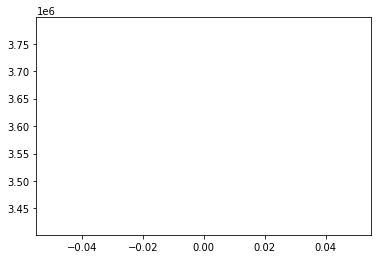

 20%|██        | 1/5 [00:00<00:00,  5.28it/s]

!!!!!!!!!!!!!!!!!!!!!!!!
eheee
/content/drive/MyDrive/Finalproject/face_videos/540.csv
/content/drive/MyDrive/Finalproject/face_videos/540.avi
True
the loop was running
10
20.0
this is the sliding_window_stride : 500
this is the sliding_window_size_frame : 15
this is the num_maps : 21
this is the start_time : 0
this is the sliding_window_stride : 500
0
1545
[0.0166666, 0.016666599999999997, 0.016666600000000004, 0.016666600000000004, 0.01666659999999999, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666600000000087

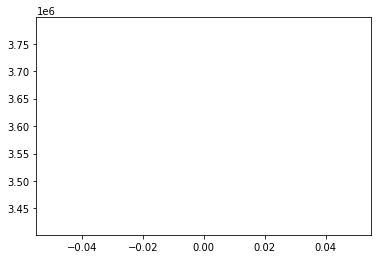

 40%|████      | 2/5 [00:01<00:02,  1.01it/s]

!!!!!!!!!!!!!!!!!!!!!!!!
eheee
/content/drive/MyDrive/Finalproject/face_videos/490.csv
/content/drive/MyDrive/Finalproject/face_videos/490.avi
True
the loop was running
10
20.0
this is the sliding_window_stride : 500
this is the sliding_window_size_frame : 15
this is the num_maps : 21
this is the start_time : 0
this is the sliding_window_stride : 500
0
1520
[0.0166666, 0.016666599999999997, 0.016666600000000004, 0.016666600000000004, 0.01666659999999999, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666600000000087

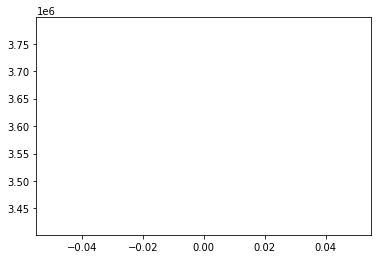

 60%|██████    | 3/5 [00:03<00:02,  1.17s/it]

!!!!!!!!!!!!!!!!!!!!!!!!
eheee
/content/drive/MyDrive/Finalproject/face_videos/580.csv
/content/drive/MyDrive/Finalproject/face_videos/580.avi
True
the loop was running
10
20.0
this is the sliding_window_stride : 500
this is the sliding_window_size_frame : 15
this is the num_maps : 21
this is the start_time : 0
this is the sliding_window_stride : 500
0
1520
[0.0166666, 0.016666599999999997, 0.016666600000000004, 0.016666600000000004, 0.01666659999999999, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666600000000087

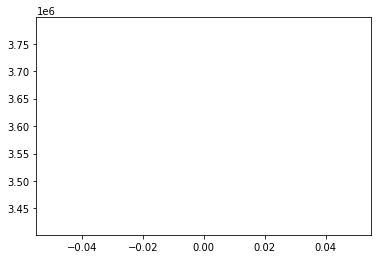

 80%|████████  | 4/5 [00:04<00:01,  1.33s/it]

!!!!!!!!!!!!!!!!!!!!!!!!
eheee
/content/drive/MyDrive/Finalproject/face_videos/710.csv
/content/drive/MyDrive/Finalproject/face_videos/710.avi
True
the loop was running
10
20.0
this is the sliding_window_stride : 500
this is the sliding_window_size_frame : 15
this is the num_maps : 21
this is the start_time : 0
this is the sliding_window_stride : 500
0
1526
[0.0166666, 0.016666599999999997, 0.016666600000000004, 0.016666600000000004, 0.01666659999999999, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666600000000004, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666599999999976, 0.01666660000000003, 0.016666599999999976, 0.01666659999999992, 0.016666600000000087

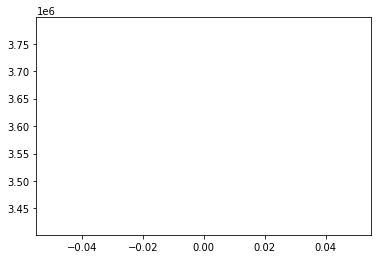

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]

!!!!!!!!!!!!!!!!!!!!!!!!
eheee


In [38]:
compute_hr_for_rhythmnet()

In [ ]:
!pip install heartpy
import glob
import numpy as np
import pandas as pd
from scipy import signal
import heartpy as hp
from tqdm import tqdm
import matplotlib.pyplot as plt


# To be used for DEAP dataset where the PPG signal is data[38]
def get_ppg_channel(x):
    # i think PPG channel is at 38
    return x[38]


# Reads the clip-wise HR data that was computed and stored in the csv files (per video)
def get_hr_data(file_name):
    hr_df = pd.read_csv(config.HR_DATA_PATH + f"{file_name}.csv")    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return hr_df["hr_bpm"].values


# Read the raw signal from the ground truth csv and resample.
# Not be needed during the model as we will compute the HRs first-hand and use them directly instead of raw signals
def read_target_data(target_data_path, video_file_name):
    signal_data_file_path = os.path.join(target_data_path, f"{video_file_name} PPG.csv")
    signal_df = pd.read_csv(signal_data_file_path)

    return signal_df["Signal"].values, signal_df["Time"].values
    # In RhythmNet maybe we don't need to resample. CHECK
    # return filter_and_resample_truth_signal(signal_df, resampling_size=3000)


# Function allows filtering and resampling of signals. Not being used for VIPL-HR
def filter_and_resample_truth_signal(signal_df, resampling_size):
    # Signal should be bandpass filtered to remove noise outside of expected HR frequency range.
    # But we are using CLEANER_PPG signals which are considered filtered.
    orignal_sample_rate = hp.get_samplerate_mstimer(signal_df["Time"].values)

    # filtered = hp.filter_signal(signal_df["Signal"].values, [0.7, 2.5], sample_rate=sample_rate,
    #                             order=3, filtertype='bandpass')
    resampled_signal = signal.resample(signal_df["Signal"].values, resampling_size, t=signal_df["Time"].values)

    # we'll need to add resampled[1]
    return resampled_signal[0], resampled_signal[1]


# Returns index of value that is nearest to the arg:value in the arg:array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# Controller Function to compute and store the HR values as csv (HR values measured clip-wise i.e. per st_map per video)
def compute_hr_for_rhythmnet():
    data_files = glob.glob(config.TARGET_SIGNAL_DIR + "*.csv")
    # for file in tqdm(data_files):
    for file in tqdm(data_files[:1]):
        file = '/Users/anweshcr7/Downloads/CleanerPPG/VIPL-HR/Cleaned/p41_v7_source2.csv'
        signal_df = pd.read_csv(file)
        signal_data, timestamps, peak_data = signal_df["Signal"].values, signal_df["Time"].values, signal_df["Peaks"].values
        video_path = config.FACE_DATA_DIR + f"{file.split('/')[-1].split('.')[0]}.avi"
        video_meta_data = get_frames_and_video_meta_data(video_path, meta_data_only=True)
        # hr_segmentwise = hp.process_segmentwise(signal_df["Signal"].values, sample_rate=128, segment_width=10, segment_overlap=0.951)
        # hr_segmentwise = hr_segmentwise[1]["bpm"]
        # plt.plot(np.arange(len(hr_segmentwise)), hr_segmentwise)
        # plt.show()
        npy_path = f"{config.ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy"
        if os.path.exists(npy_path):
            video_meta_data["num_maps"] = np.load(f"{config.ST_MAPS_PATH}{file.split('/')[-1].split('.')[0]}.npy").shape[0]
        else:
            continue
        hr = np.asarray(calculate_hr_clip_wise(timestamps, signal_df, video_meta_data), dtype="float32")
        file_name = file.split("/")[-1].split(".")[0].split(" ")[0]
        hr_df = pd.DataFrame(hr, columns=["hr_bpm"])
        hr_df.to_csv(f"../data/hr_csv/{file_name}.csv", index=False)
        # print("eheee")


# Function to compute and store the HR values as csv (HR values measured clip-wise i.e. per st_map per video)
def calculate_hr_clip_wise(timestamps=None, signal_df=None, video_meta_data=None):

    sliding_window_stride = int((video_meta_data["sliding_window_stride"]/video_meta_data["frame_rate"])*1000)
    sliding_window_size_frame = int((config.CLIP_SIZE/video_meta_data["frame_rate"]))
    # convert to milliseconds
    sliding_window_size = sliding_window_size_frame * 1000
    # num_maps = int((video_meta_data["num_frames"] - config.CLIP_SIZE)/sliding_window_size_frame) + 1
    num_maps = video_meta_data["num_maps"]
    # for i in range(len(timestamps)):
    #     print(timestamps[i+1]-timestamps[i])
    count = 0
    hr_list = []
    for start_time in range(0, int(timestamps[-1]), sliding_window_stride):
        if count == num_maps:
            break
        # start_index = np.where(timestamps == start_time)
        end_time = start_time + sliding_window_size
        # end_index = np.where(timestamps == end_time)
        start_index = np.searchsorted(timestamps, start_time, side='left')
        end_index = np.searchsorted(timestamps, end_time, side='left')

        # start_index = start_index[0][0]
        if end_index == 0:
            end_index = len(timestamps) - 1
            # break

        curr_data = signal_df.iloc[start_index:end_index]
        time_intervals = curr_data[curr_data["Peaks"] == 1]["Time"].values
        ibi_array = [time_intervals[idx + 1] - time_intervals[idx] for idx, time_val in enumerate(time_intervals[:-1])]
        if len(ibi_array) == 0:
            hr_bpm = hr_list[-1]
        else:
            hr_bpm = 1000/np.mean(ibi_array)*60
        hr_list.append(hr_bpm)

        count += 1


    # plt.plot(np.arange(len(hr_list)), hr_list)
    # plt.show()
    return hr_list


# Function to compute HR from raw signal.
def calculate_hr(signal_data, timestamps=None):
    sampling_rate = 47.63
    if timestamps is not None:
        sampling_rate = hp.get_samplerate_mstimer(timestamps)
        try:
            wd, m = hp.process(signal_data, sample_rate=sampling_rate)
            hr_bpm = m["bpm"]
        except:
            hr_bpm = 75.0

        if np.isnan(hr_bpm):
            hr_bpm = 75.0
        return hr_bpm

    else:
        # We are working with predicted HR:
        # need to filter and do other stuff.. lets see
        signal_data = hp.filter_signal(signal_data, cutoff=[0.7, 2.5], sample_rate=sampling_rate, order=6,
                                       filtertype='bandpass')
        try:
            wd, m = hp.process(signal_data, sample_rate=sampling_rate, high_precision=True, clean_rr=True)
            hr_bpm = m["bpm"]
        except:
            print("BadSignal received (could not be filtered) using def HR value = 75bpm")
            hr_bpm = 75.0
        return hr_bpm


if __name__ == '__main__':
    compute_hr_for_rhythmnet()

    files = glob.glob(config.HR_DATA_PATH+"/*.csv")
    for file in files:
        hr = get_hr_data(file.split('/')[-1].split('.')[0])
        if type(hr) == np.object_:
            print(file)
        try:
            torch.tensor(hr, dtype=torch.float)
        except:
            print(file)

     |████████████████████████████████| 1.0 MB 5.4 MB/s 


NameError: ignored

In [ ]:

frames, frameRate, sliding_window_stride = get_frames_and_video_meta_data("/content/drive/MyDrive/Finalproject/face_videos/490.avi")

# num_frames = frames.shape[0]
# output_shape = (frames.shape[1], frames.shape[2])
# num_maps = int((num_frames - 300)/sliding_window_stride + 1)

461721600


In [ ]:
print(frames.shape)

(501, 480, 640, 3)


In [ ]:
import glob
# maps = preprocess_video_to_st_maps(
#         video_path="/content/drive/MyDrive/Finalproject/DATA/490.avi",
#         output_shape=(180, 180), clip_size=300)

data_files = glob.glob( "/content/drive/MyDrive/Finalproject/DATA/" +"*.avi")


In [ ]:
from pandas.io.parsers.readers import read_csv
data1 = read_csv("/content/sample_data/california_housing_train.csv")
print(data1)
hr_df = pd.DataFrame(sample_time, columns=["sample_time4"])
print(hr_df)
res = pd.concat([data1, hr_df] , axis=1)
print(res)

# hr_df.to_csv("/content/sample_data/california_housing_test.csv", sep = ',')
# print(data1)


       longitude  latitude  ...  median_income  median_house_value
0        -114.31     34.19  ...         1.4936             66900.0
1        -114.47     34.40  ...         1.8200             80100.0
2        -114.56     33.69  ...         1.6509             85700.0
3        -114.57     33.64  ...         3.1917             73400.0
4        -114.57     33.57  ...         1.9250             65500.0
...          ...       ...  ...            ...                 ...
16995    -124.26     40.58  ...         2.3571            111400.0
16996    -124.27     40.69  ...         2.5179             79000.0
16997    -124.30     41.84  ...         3.0313            103600.0
16998    -124.30     41.80  ...         1.9797             85800.0
16999    -124.35     40.54  ...         3.0147             94600.0

[17000 rows x 9 columns]
      sample_time4
0         0.016667
1         0.033333
2         0.050000
3         0.066666
4         0.083333
...            ...
1515     25.266566
1516     25.283232

In [ ]:
print(len(sample_time))

1520
